In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd

from scipy import signal

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, acovf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import mse, rmse, meanabs, stde

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()


In [3]:
url = "/content/drive/Shareddrives/Ciencia de datos y asi/Data/2012_2019_PlatteRiverWeir_features_merged_all.csv"
df = pd.read_csv(url)
df

,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,CalcTimestamp,width,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
0,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:28,4288,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:33,4288,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T16:58:40,4288,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,2012-06-09 14:45:00,2012-06-09T14:44:30,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:47,4288,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,2012-06-09 15:45:00,2012-06-09T15:44:59,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:55,4288,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42054,2019-10-11 09:00:00,2019-10-11T08:59:53,StateLineWeir_20191011_Farrell_409.jpg,USGS,6674500,MDT,2.54,434.0,2020-03-12T16:23:53,4288,...,2446,1900,9284.0,77521.0,38385.370066,15952.029728,0.0,70085.0,37550.894823,16444.401209
42055,2019-10-11 10:00:00,2019-10-11T09:59:52,StateLineWeir_20191011_Farrell_410.jpg,USGS,6674500,MDT,2.54,434.0,2020-03-12T16:23:54,4288,...,2440,1900,10092.0,74614.0,40162.989292,15467.708856,0.0,70061.0,39397.339095,16009.008049
42056,2019-10-11 11:00:00,2019-10-11T10:59:52,StateLineWeir_20191011_Farrell_411.jpg,USGS,6674500,MDT,2.54,434.0,2020-03-12T16:23:55,4288,...,2447,1900,7067.0,83260.0,42095.946590,16770.357949,0.0,76335.0,41350.006568,17489.374617
42057,2019-10-11 12:00:00,2019-10-11T11:59:53,StateLineWeir_20191011_Farrell_412.jpg,USGS,6674500,MDT,2.54,434.0,2020-03-12T16:23:56,4288,...,2443,1900,6283.0,83045.0,45345.490954,17498.432849,0.0,78882.0,44553.920296,18268.294896


In [4]:
x = pd.to_datetime(df[' CaptureTime'], format="%Y-%m-%d %H:%M:%S")

time = []
for day in x:
  time.append(day.timestamp())
  
df["CaptureTimeSeconds"] = time
df["datetime"] = x


In [5]:
df = df.set_index('datetime')
df

,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,CalcTimestamp,width,...,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma,CaptureTimeSeconds
datetime,,,,,,,,,,,,,,,,,,,,,
2012-06-09 13:09:07,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:28,4288,...,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.339247e+09
2012-06-09 13:10:29,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:33,4288,...,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.339247e+09
2012-06-09 13:44:01,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T16:58:40,4288,...,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.339249e+09
2012-06-09 14:44:30,2012-06-09 14:45:00,2012-06-09T14:44:30,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:47,4288,...,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.339253e+09
2012-06-09 15:44:59,2012-06-09 15:45:00,2012-06-09T15:44:59,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:55,4288,...,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.339257e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-11 08:59:53,2019-10-11 09:00:00,2019-10-11T08:59:53,StateLineWeir_20191011_Farrell_409.jpg,USGS,6674500,MDT,2.54,434.0,2020-03-12T16:23:53,4288,...,1900,9284.0,77521.0,38385.370066,15952.029728,0.0,70085.0,37550.894823,16444.401209,1.570784e+09
2019-10-11 09:59:52,2019-10-11 10:00:00,2019-10-11T09:59:52,StateLineWeir_20191011_Farrell_410.jpg,USGS,6674500,MDT,2.54,434.0,2020-03-12T16:23:54,4288,...,1900,10092.0,74614.0,40162.989292,15467.708856,0.0,70061.0,39397.339095,16009.008049,1.570788e+09
2019-10-11 10:59:52,2019-10-11 11:00:00,2019-10-11T10:59:52,StateLineWeir_20191011_Farrell_411.jpg,USGS,6674500,MDT,2.54,434.0,2020-03-12T16:23:55,4288,...,1900,7067.0,83260.0,42095.946590,16770.357949,0.0,76335.0,41350.006568,17489.374617,1.570792e+09


In [6]:
y = df[' Stage']

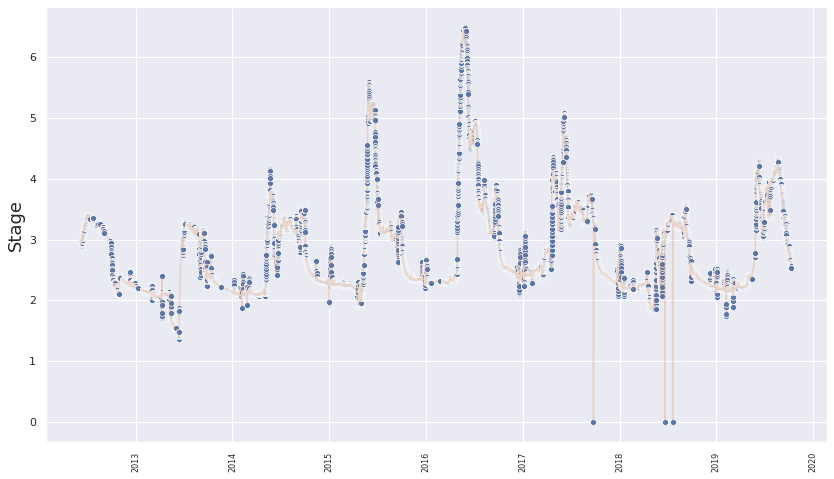

In [7]:
plt.figure(figsize=(14,8))

sns.lineplot(data = y, marker= "o", lw=0)
sns.lineplot(data = y, alpha = 0.25)
plt.xticks(rotation = 90, size=8)
plt.xlabel("")
plt.ylabel('Stage', fontsize = 18)
plt.legend().remove()

* Prueba Dickey-Fuller: 0.002

Se rechaza hipótesis nula de que la serie de tiempo no es estacionaria porque tiene una raíz unitaria.

* Prueba KPSS: 0.01

Se rechaza hipótesis nula de que la serie de tiempo si es estacionaria con tendencia determinista.

De acuerdo a la gráfica de la serie de tiempo y a la prueba KPSS se puede concluir que el modelo no es estacionario, ya que se puede observar estacionalidad con periodo de un año.

In [8]:
# Prueba Dickey_Fuller:
print('Prueba Dickey-Fuller:')
dftest = adfuller(y)
dfoutput = pd.Series(dftest[0:4], index = ['Estadístico de prueba', 'p-valor', '#Lags usados', 'Número de observaciones usadas'])
for key, value in dftest[4].items():
    dfoutput['Valor crítico (%s)' %key] = value
print(dfoutput)

# Prueba KPSS:
print('\nPrueba KPSS:')
kpsstest = kpss(y, regression='c')
kpss_output = pd.Series(kpsstest[0:3], index=['Estadístico de prueba','p-valor','#Lags usados'])
for key,value in kpsstest[3].items():
    kpss_output['Valor crítico (%s)'%key] = value
print (kpss_output)

Prueba Dickey-Fuller:
Estadístico de prueba                -3.860832
p-valor                               0.002343
#Lags usados                         38.000000
Número de observaciones usadas    42020.000000
Valor crítico (1%)                   -3.430506
Valor crítico (5%)                   -2.861609
Valor crítico (10%)                  -2.566807
dtype: float64

Prueba KPSS:
Estadístico de prueba      1.161027
p-valor                    0.010000
#Lags usados             120.000000
Valor crítico (10%)        0.347000
Valor crítico (5%)         0.463000
Valor crítico (2.5%)       0.574000
Valor crítico (1%)         0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


In [9]:
df = df[pd.to_datetime(df['SensorTime']).dt.year > 2012]

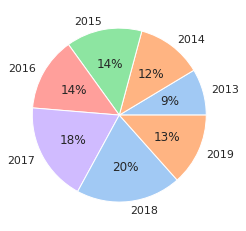

[3465, 4910, 5674, 5533, 7390, 7852, 5396]


In [10]:
yearData = []
labels = []
year = 2013

for i in range(7):
  labels.append(str(year))
  yearData.append(df[pd.to_datetime(df['SensorTime']).dt.year == year].shape[0])
  year += 1

colors = sns.color_palette('pastel')[0:5]

plt.pie(yearData, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()
print(yearData)

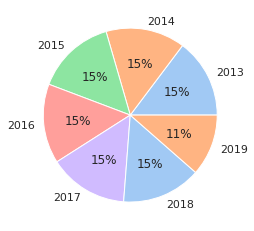

[8750, 8760, 8760, 8784, 8760, 8760, 6805]


In [11]:
df1 = df.resample('60min').mean().interpolate().copy()

yearData = []
labels = []
year = 2013

for i in range(7):
  labels.append(str(year))
  yearData.append(df1[df1.index.year == year].shape[0])
  year += 1

colors = sns.color_palette('pastel')[0:5]

plt.pie(yearData, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()
print(yearData)

In [12]:
y = df1[' Stage']

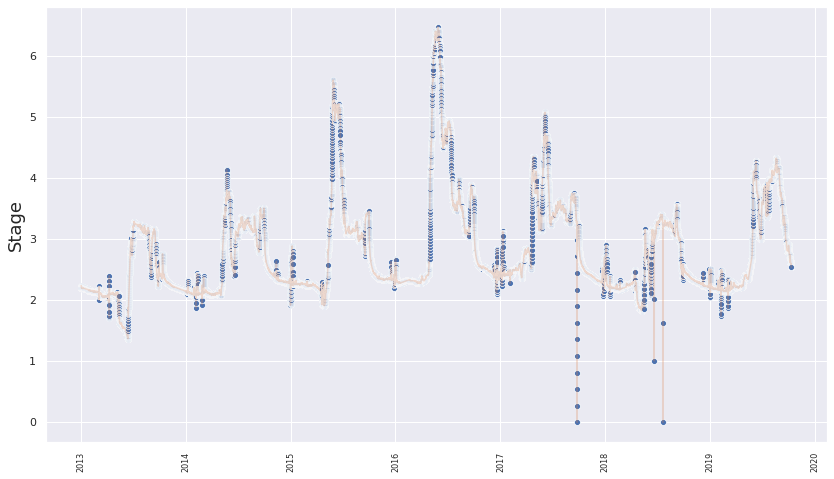

In [13]:
plt.figure(figsize=(14,8))

sns.lineplot(data = y, marker= "o", lw=0)
sns.lineplot(data = y, alpha = 0.25)
plt.xticks(rotation = 90, size=8)
plt.xlabel("")
plt.ylabel('Stage', fontsize = 18)
plt.legend().remove()

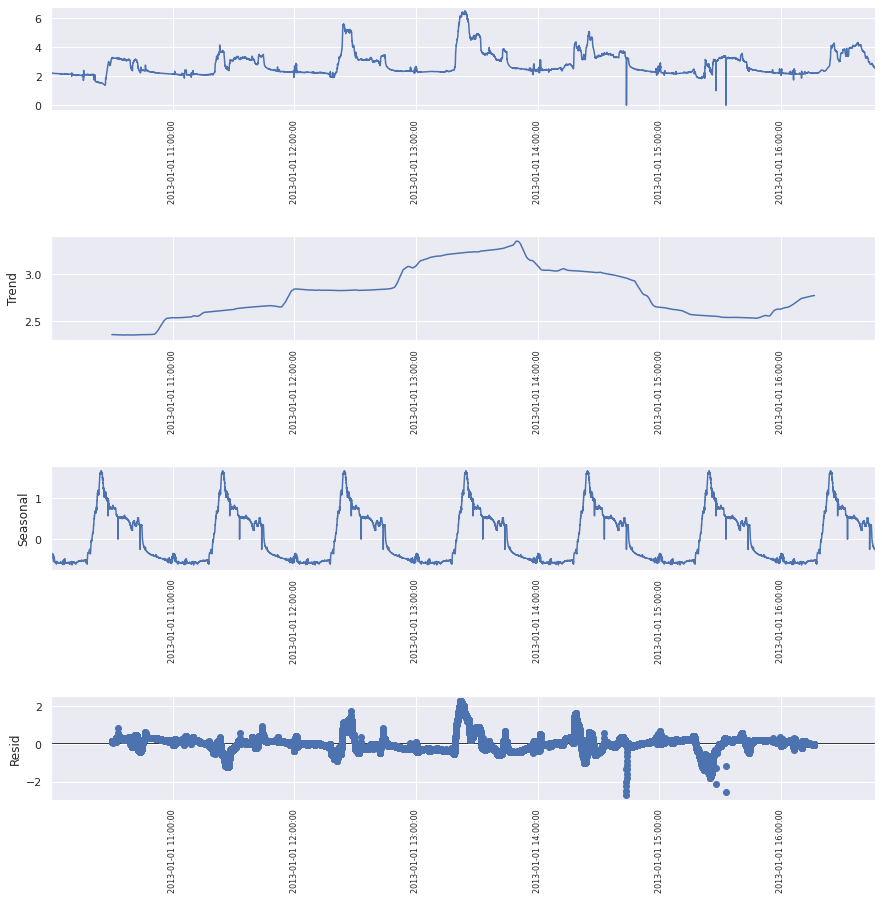

In [14]:
# Descomposición
dec = seasonal_decompose(y, model='additive', period=8760)

fig = dec.plot()
fig.set_figwidth(14)
fig.set_figheight(14)

for ax in fig.axes:
    ax.set_title("")
    ax.set_xticklabels(y.index, rotation = 90, size=8)

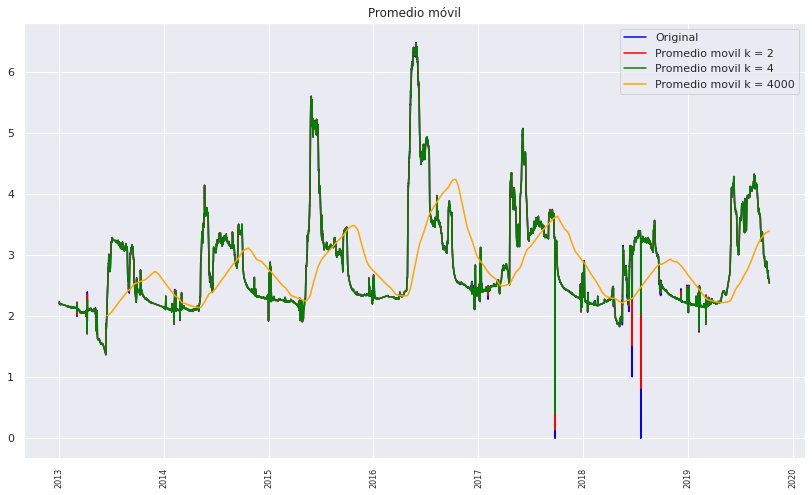

In [15]:
# Promedio móvil a diferentes números de retraso
rolmean12 = y.rolling(window = 4000).mean()
rolmean4 = y.rolling(window = 4).mean()
rolmean2 = y.rolling(window = 2).mean()
    
plt.figure(figsize=(14,8))
plt.plot(y, color = 'blue', label = 'Original')
plt.plot(rolmean2, color = 'red', label = 'Promedio movil k = 2')
plt.plot(rolmean4, color = 'green', label = 'Promedio movil k = 4')
plt.plot(rolmean12, color = 'orange', label = 'Promedio movil k = 4000')

plt.legend(loc = 'best')
plt.title('Promedio móvil')
plt.xticks(rotation = 90, size=8)
plt.show()

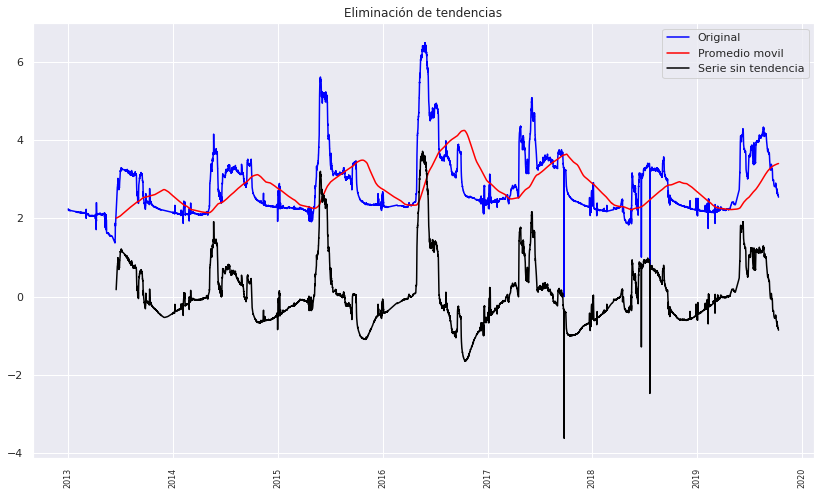

In [16]:
# Eliminación de la tendencia con promedios móviles
rolmean = y.rolling(window = 4000).mean()
dt = y - rolmean
dt.dropna(inplace = True)


plt.figure(figsize=(14,8))
plt.plot(y, color = 'blue', label = 'Original')
plt.plot(rolmean, color = 'red', label = 'Promedio movil')
plt.plot(dt, color = 'black', label = 'Serie sin tendencia')
plt.legend(loc = 'best')
plt.title('Eliminación de tendencias')
plt.xticks(rotation = 90, size=8)
plt.show()

* Prueba Dickey-Fuller: 0.005

Se rechaza hipótesis nula de que la serie de tiempo no es estacionaria porque tiene una raíz unitaria.

* Prueba KPSS: 0.095497

No se rechaza hipótesis nula de que la serie de tiempo si es estacionaria con tendencia determinista.

In [17]:
# Prueba Dickey_Fuller:
print('Prueba Dickey-Fuller:')
dftest = adfuller(dt)
dfoutput = pd.Series(dftest[0:4], index = ['Estadístico de prueba', 'p-valor', '#Lags usados', 'Número de observaciones usadas'])
for key, value in dftest[4].items():
    dfoutput['Valor crítico (%s)' %key] = value
print(dfoutput)

# Prueba KPSS:
print('\nPrueba KPSS:')
kpsstest = kpss(dt, regression='c')
kpss_output = pd.Series(kpsstest[0:3], index=['Estadístico de prueba','p-valor','#Lags usados'])
for key,value in kpsstest[3].items():
    kpss_output['Valor crítico (%s)'%key] = value
print (kpss_output)

Prueba Dickey-Fuller:
Estadístico de prueba                -3.595998
p-valor                               0.005838
#Lags usados                         48.000000
Número de observaciones usadas    55331.000000
Valor crítico (1%)                   -3.430468
Valor crítico (5%)                   -2.861592
Valor crítico (10%)                  -2.566798
dtype: float64

Prueba KPSS:
Estadístico de prueba      0.357448
p-valor                    0.095497
#Lags usados             139.000000
Valor crítico (10%)        0.347000
Valor crítico (5%)         0.463000
Valor crítico (2.5%)       0.574000
Valor crítico (1%)         0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'k')

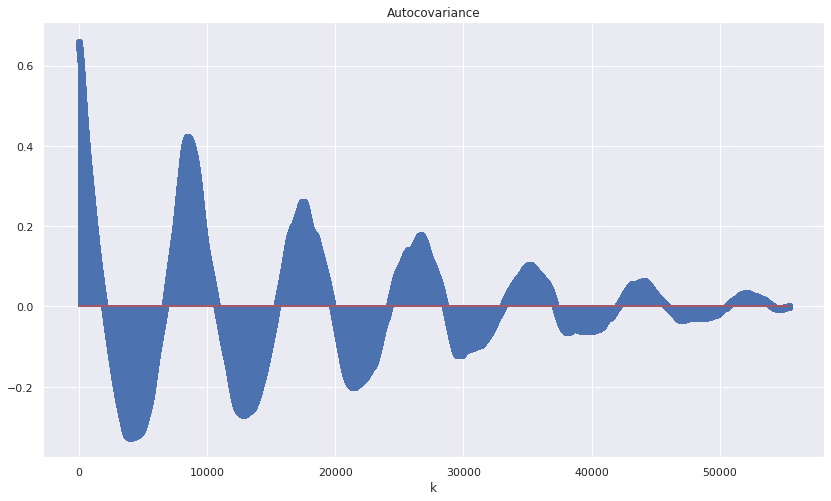

In [18]:
# Gráfica de la autocovarianza
plt.figure(figsize=(14,8))
plt.stem(acovf(dt))
plt.title("Autocovariance")
plt.xlabel("k")

In [19]:
# Gráfica de la autocorrelación
fig = plot_acf(dt)
fig.set_figwidth(14)
fig.set_figheight(8)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


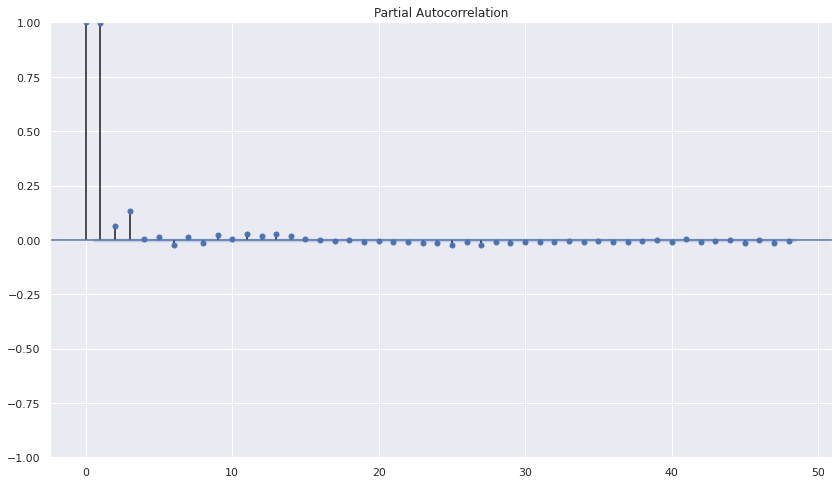

In [20]:
# Gráfica de la autocorrelación parcial
fig = plot_pacf(dt)
fig.set_figwidth(14)
fig.set_figheight(8)

In [ ]:
# Búsqueda de un modelo óptimo
# model = auto_arima(dt, min_p= 2, max_q= 15, d = 0, max_d= 3, seasonal = False, trace=True, error_action='raise')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-248195.719, Time=6.65 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=134288.195, Time=2.61 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=3.80 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=59736.554, Time=7.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-248180.910, Time=3.51 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-247034.995, Time=32.50 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-248192.091, Time=6.05 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-248197.592, Time=6.70 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-248197.747, Time=7.91 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-51102.133, Time=13.52 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-248195.766, Time=7.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-2667.281, Time=11.49 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-84941.734, Time=23.88 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-248232.093, Time=31.13 sec
 

In [77]:
# Ejemplo de ajuste de modelo ARIMA
model = ARIMA(dt, order=(2, 0, 5))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Stage   No. Observations:                55380
Model:                 ARIMA(2, 0, 5)   Log Likelihood              124133.045
Date:                Tue, 29 Nov 2022   AIC                        -248248.090
Time:                        00:31:32   BIC                        -248167.792
Sample:                    06-17-2013   HQIC                       -248223.056
                         - 10-11-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0574      0.410      0.140      0.889      -0.746       0.861
ar.L1          0.4880      0.037     13.143      0.000       0.415       0.561
ar.L2          0.5115      0.037     13.772      0.0

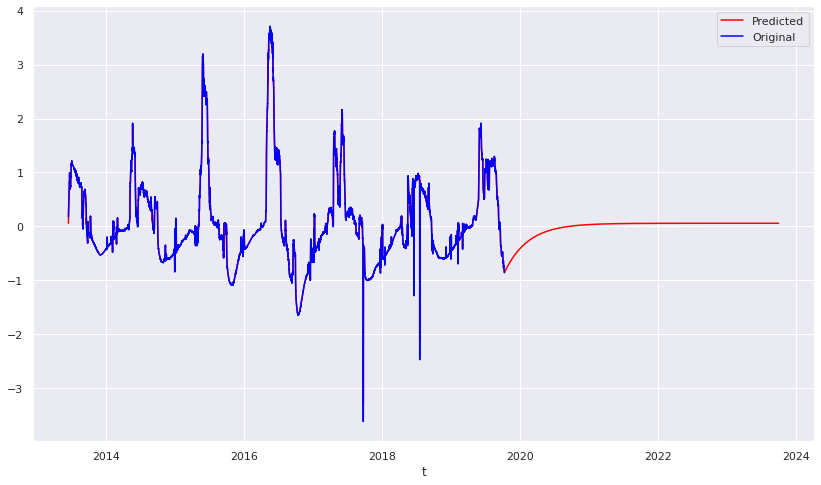

In [78]:
# Pronósticos con el modelo
n = df.shape[0]

nstart = 0
nend = n + 50000
forecast = model_fit.predict(start=nstart, end=nend)

plt.figure(figsize=(14,8))
plt.plot(forecast.index , forecast, color = 'red', label='Predicted')
plt.plot( dt.index, dt.to_numpy(), color = 'blue', label = 'Original')
plt.xlabel("t")
plt.legend()

In [70]:
y = dt[(dt.index.year >= 2018) & (dt.index.year < 2020)]

In [71]:
y_pred = forecast.loc[y.index]

In [72]:
print("MSE: ", mse(y.squeeze(), y_pred))
print("RSMSE: ", rmse(y.squeeze(), y_pred))
print("MAE: ", meanabs(y.squeeze(), y_pred))
print("Error estandar: ", stde(y.squeeze(), y_pred, ddof = 3))

MSE:  0.0015717899892563685
RSMSE:  0.03964580670457304
MAE:  0.0059265481842881605
Error estandar:  0.03964962566922512
